### Model Training Pipeline

This notebook retrains the model and saves the model and performance metrics (Accuracy and AUC) to the Hopsworks.ai Model Registry.

It executes Notebook 07 as part of the process and will use parameters as set there (GPU/no GPU, retune Hyperparameters or not, etc...).

Notebook 07 is executed as a subprocess and the output is captured and displayed in this notebook.

Notebook 07 includes experiment tracking with Neptune.ai.

In [1]:
import os

import pandas as pd
import numpy as np

import hopsworks

from hsml.schema import Schema
from hsml.model_schema import ModelSchema
from hsfs.client.exceptions import RestAPIError

from pathlib import Path  #for Windows/Linux compatibility
DATAPATH = Path(r'data')

import json

from datetime import datetime, timedelta

from src.hopsworks_utils import (
    convert_feature_names,
)

from dotenv import load_dotenv



**Connect to Hopsworks FeatureStore**

In [2]:
try:
    HOPSWORKS_API_KEY = os.environ['HOPSWORKS_API_KEY']
except:
    raise Exception('Set environment variable HOPSWORKS_API_KEY')

In [3]:
project = hopsworks.login(api_key_value=HOPSWORKS_API_KEY)
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/3350
Connected. Call `.close()` to terminate connection gracefully.


In [4]:
rolling_stats_fg = fs.get_or_create_feature_group(
    name="rolling_stats",
    version=2,
)

**Delete Old FeatureView**

In [5]:
try:
    feature_view = fs.get_feature_view(
        name = 'rolling_stats_fv',
        version = 2,
    )
    feature_view.delete()
except Exception:
    print("Feature view does not exist. No need to delete it.")



Feature view does not exist. No need to delete it.


**Create New FeatureView**

In [6]:
query = rolling_stats_fg.select_all()

feature_view = fs.create_feature_view(
    name = 'rolling_stats_fv',
    version = 2,
    query = query
)

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/3350/fs/3297/fv/rolling_stats_fv/version/2


**Create Training and Test Set**

Use time filter: Previous 365 days is test set, all others are training set

In [7]:
STARTDATE = "2003-01-01" #data goes back to 2003 season
TODAY = datetime.now()
LASTYEAR = (TODAY - timedelta(days=45)).strftime('%Y-%m-%d')
TODAY = TODAY.strftime('%Y-%m-%d') 

td_train, td_job = feature_view.create_training_data(
        start_time=STARTDATE,
        end_time=LASTYEAR,    
        description='All data except last 45 days',
        data_format="csv",
        coalesce=True,
        write_options={'wait_for_job': False},
    )

td_test, td_job = feature_view.create_training_data(
        start_time=LASTYEAR,
        end_time=TODAY,    
        description='Last 45 days',
        data_format="csv",
        coalesce=True,
        write_options={'wait_for_job': False},
    )


Training dataset job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/3350/jobs/named/rolling_stats_fv_2_1_create_fv_td_01032023145120/executions


Training dataset job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/3350/jobs/named/rolling_stats_fv_2_2_create_fv_td_01032023145121/executions


In [8]:
train = feature_view.get_training_data(td_train)[0]
test = feature_view.get_training_data(td_test)[0]


**Re-Convert Feature Names**

- For whatever reason, hopsworks.ai converts all feature names to lowercase. 
- For reusability of existing codebase, these need to be converted back to original mixed-case in train and test dataframes.
- The original feature names in proper mixed-case is read from a JSON file, then mapped back to train and test

In [9]:

train = convert_feature_names(train)
test = convert_feature_names(test)

#fix date format
train["GAME_DATE_EST"] = train["GAME_DATE_EST"].str[:10]
test["GAME_DATE_EST"] = test["GAME_DATE_EST"].str[:10]


In [10]:
train

,GAME_DATE_EST,GAME_ID,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,...,FG3_PCT_AVG_LAST_10_ALL_x_minus_y,FG3_PCT_AVG_LAST_15_ALL_x_minus_y,AST_AVG_LAST_3_ALL_x_minus_y,AST_AVG_LAST_7_ALL_x_minus_y,AST_AVG_LAST_10_ALL_x_minus_y,AST_AVG_LAST_15_ALL_x_minus_y,REB_AVG_LAST_3_ALL_x_minus_y,REB_AVG_LAST_7_ALL_x_minus_y,REB_AVG_LAST_10_ALL_x_minus_y,REB_AVG_LAST_15_ALL_x_minus_y
0,2018-01-05,21700570,1610612738,1610612750,2017,91,0.404053,0.691895,0.166992,24,...,0.102191,0.069267,3.333333,0.142857,-0.2,-0.933333,9.666667,4.857143,5.8,2.666667
1,2006-12-11,20600301,1610612753,1610612756,2006,89,0.451904,0.523926,0.166992,18,...,-0.162610,-0.131071,-18.333333,-12.000000,-10.9,-9.066667,-4.333333,-6.285714,-3.3,-1.133333
2,2007-11-10,20700084,1610612758,1610612750,2007,100,0.405029,0.850098,0.399902,12,...,-0.020862,-0.024093,-7.333333,-5.142857,-2.1,-1.666667,-6.000000,-6.285714,-4.8,-1.866667
3,2005-01-11,20400504,1610612760,1610612746,2004,104,0.437988,0.889160,0.500000,24,...,0.031708,0.059005,-5.333333,-1.428571,-2.8,-2.600000,-5.000000,-1.714286,-0.9,-1.000000
4,2016-10-29,21600028,1610612752,1610612763,2016,111,0.525879,0.641113,0.285889,24,...,-0.001685,0.031828,-0.666667,1.285714,1.9,1.933333,1.000000,2.571429,1.7,3.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23409,2006-11-14,20600106,1610612762,1610612746,2006,112,0.512207,0.734863,0.272949,25,...,0.048035,0.054403,6.000000,6.285714,5.5,5.133333,1.333333,1.285714,-0.8,-1.466667
23410,2004-01-25,20300630,1610612750,1610612756,2003,99,0.438965,0.750000,0.428955,26,...,-0.097675,-0.036251,0.000000,-2.142857,0.1,2.400000,-3.666667,-1.428571,1.5,2.733333
23411,2004-12-27,20400392,1610612764,1610612766,2004,106,0.547852,0.732910,0.333008,18,...,-0.117731,-0.092631,-0.666667,-1.428571,-1.3,-1.666667,0.666667,-2.714286,0.2,2.666667
23412,2022-12-28,22200521,1610612762,1610612744,2022,107,40.687500,69.187500,32.593750,26,...,-0.592188,0.780208,-10.333333,-6.428571,-5.4,-5.733333,-2.666667,-0.714286,-1.5,-1.466667


**Save data**

As a convenience to re-use the existing model training notebook, the data is saved to files first (currently <100 megabytes total)

In [11]:
train.to_csv(DATAPATH / "train_selected.csv",index=False)
test.to_csv(DATAPATH / "test_selected.csv",index=False)

**Model Training**

The existing model training notebook is re-used. It includes Neptune.ai experiment tracking for both training run and hyperparameter tuning.


XGB version: 1.6.1
LGB version: 3.3.2


Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
distutils Version classes are deprecated. Use packaging.version instead.
distutils Version classes are deprecated. Use packaging.version instead.


https://app.neptune.ai/cmunch1/nba-prediction/e/NBAP-146
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


1it [00:05,  5.38s/it]


Scores:

Accuracy Score: 0.650437753576767
AUC Score: 0.6954571063161314
Optimal Threshold: 0.54932725


2it [00:10,  5.15s/it]


Scores:

Accuracy Score: 0.6423232970318172
AUC Score: 0.6916483387485275
Optimal Threshold: 0.56797856


3it [00:15,  5.17s/it]


Scores:

Accuracy Score: 0.6365577621183003
AUC Score: 0.6940619040622741
Optimal Threshold: 0.5998805


4it [00:20,  5.13s/it]


Scores:

Accuracy Score: 0.6286568439034806
AUC Score: 0.6942989239521309
Optimal Threshold: 0.6203361


5it [00:25,  5.16s/it]


Scores:

Accuracy Score: 0.6375480563861597
AUC Score: 0.6816953187160666
Optimal Threshold: 0.5576675

Scores:

Accuracy Score: 0.6421371828820364
AUC Score: 0.6913730272290555
Optimal Threshold: 0.5652856230735779
CPU times: total: 43 s
Wall time: 25.8 s
[[6117 3768]
 [4611 8918]]


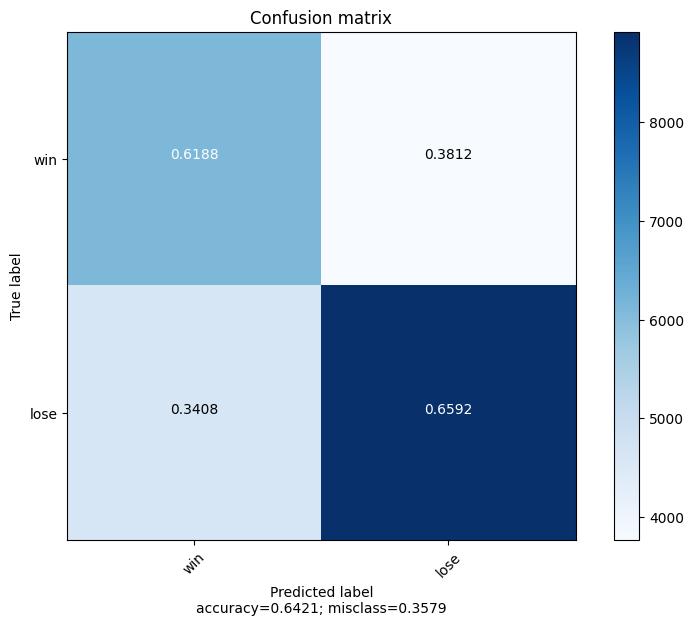

              precision    recall  f1-score   support

           0       0.57      0.62      0.59      9885
           1       0.70      0.66      0.68     13529

    accuracy                           0.64     23414
   macro avg       0.64      0.64      0.64     23414
weighted avg       0.65      0.64      0.64     23414



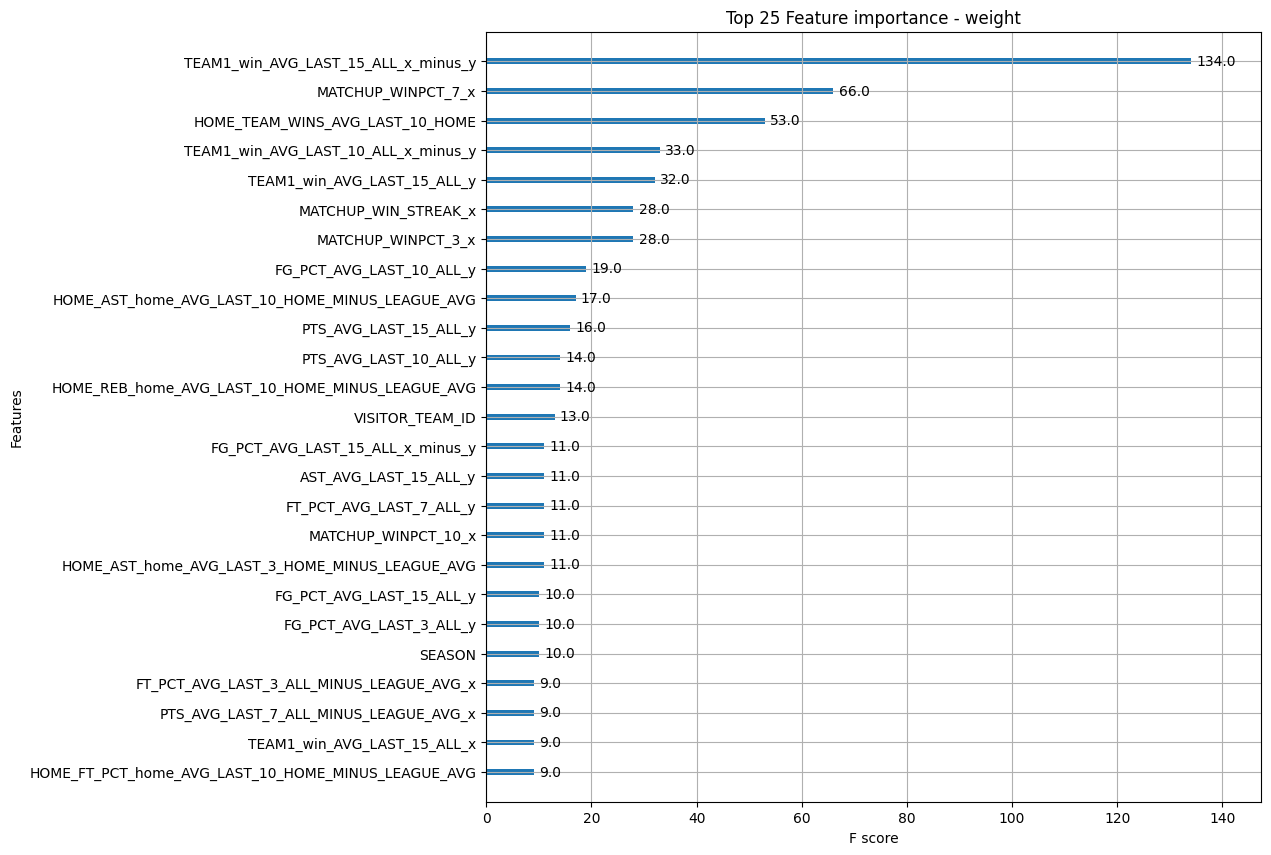

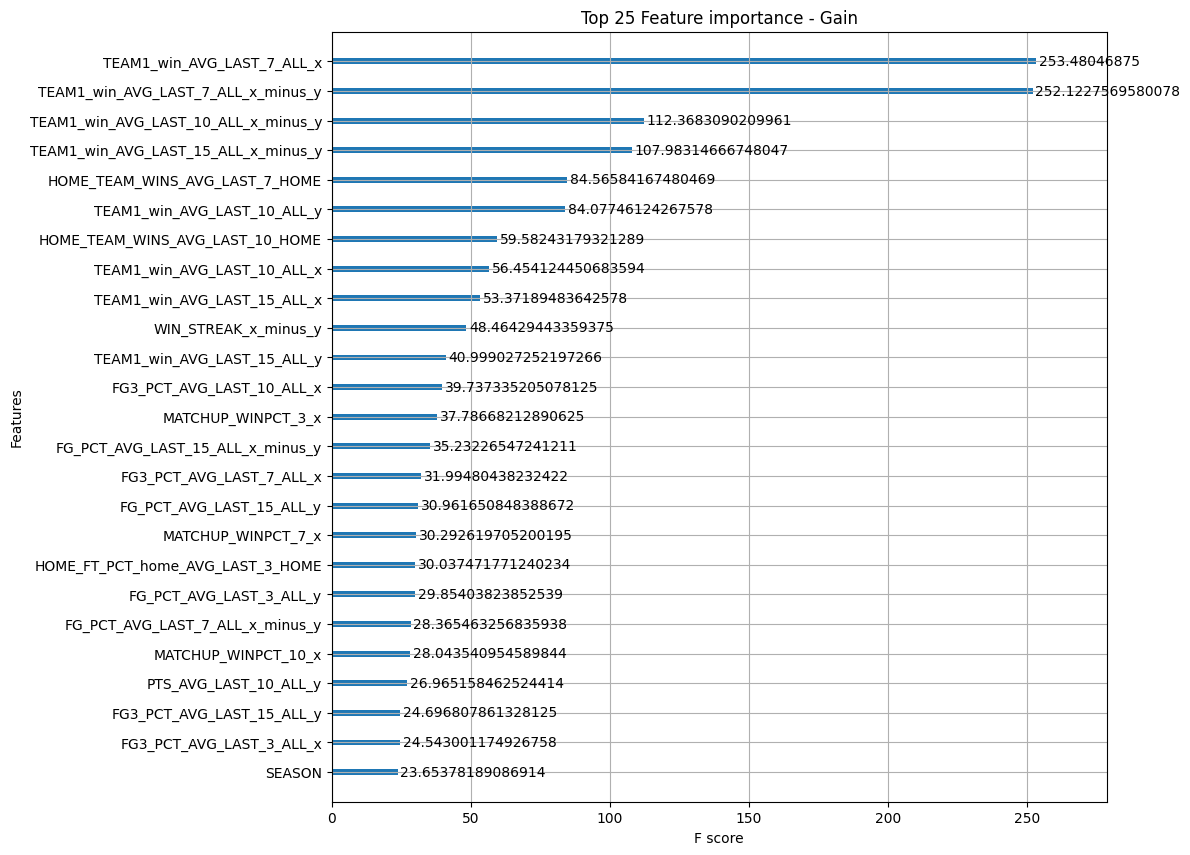

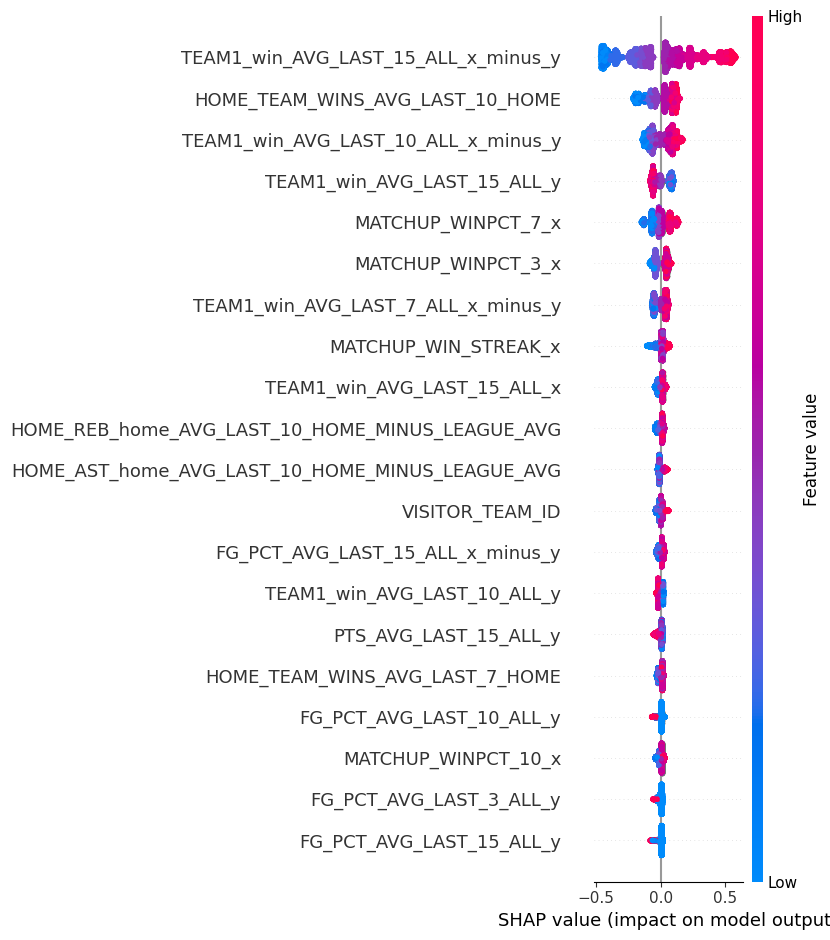

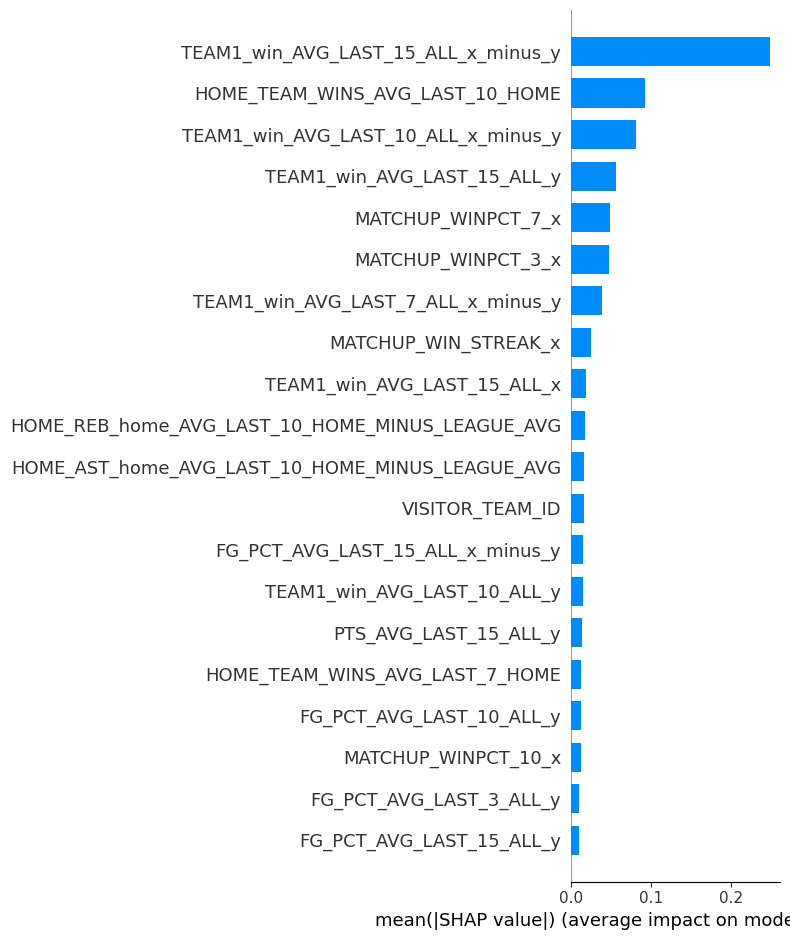


Scores:

Accuracy Score: 0.6584507042253521
AUC Score: 0.6314368770764119
Optimal Threshold: 0.5325491
[[143  29]
 [ 68  44]]


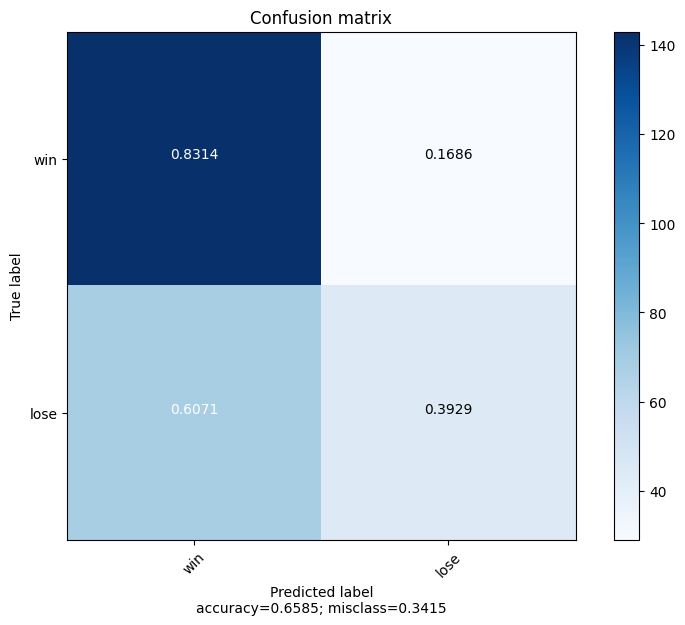

              precision    recall  f1-score   support

           0       0.68      0.83      0.75       172
           1       0.60      0.39      0.48       112

    accuracy                           0.66       284
   macro avg       0.64      0.61      0.61       284
weighted avg       0.65      0.66      0.64       284



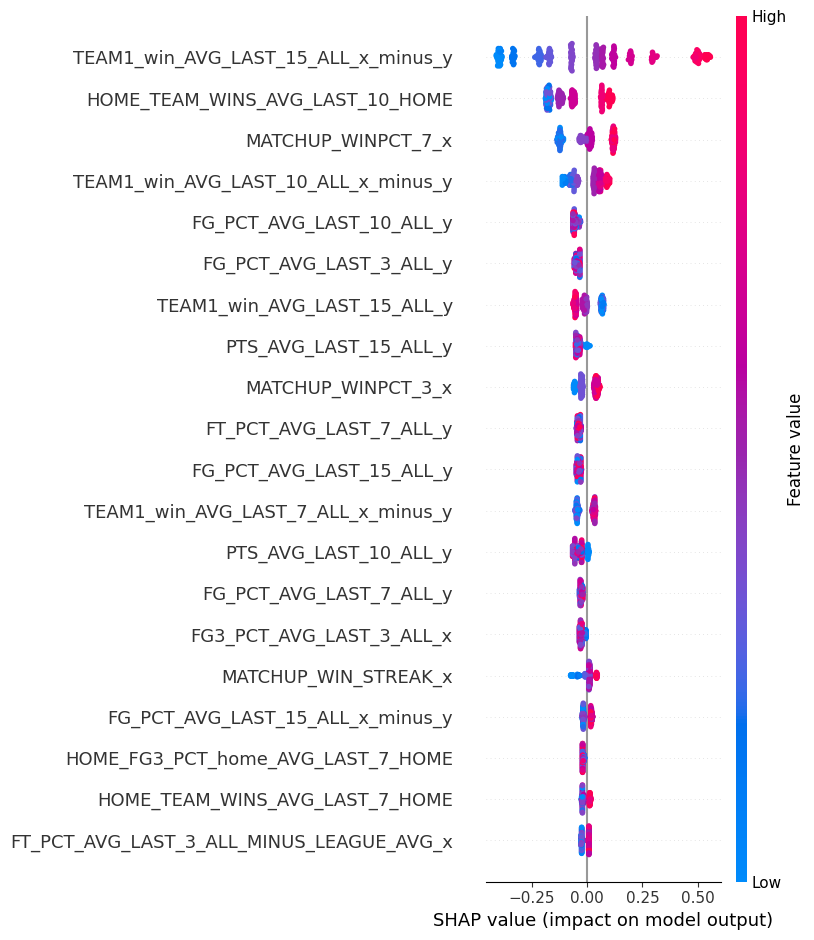

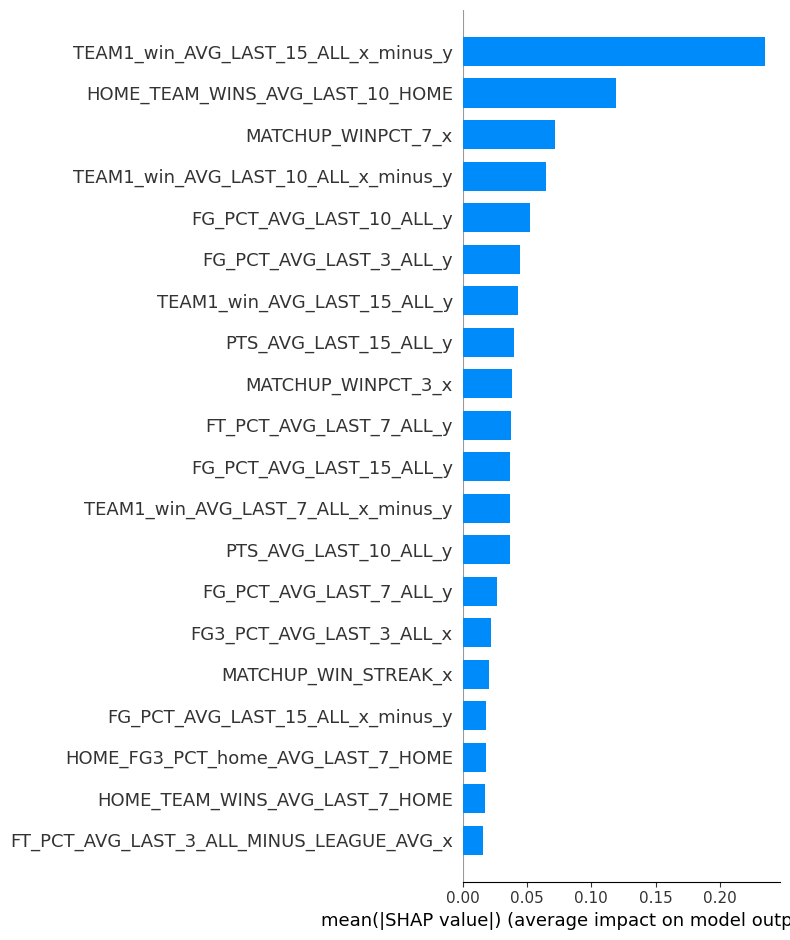

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284 entries, 55 to 15
Columns: 245 entries, GAME_DATE_EST to REB_AVG_LAST_15_ALL_x_minus_y
dtypes: datetime64[ns](1), float16(222), int32(1), int8(21)
memory usage: 134.5 KB
TEST1

Scores:

Accuracy Score: 0.6544117647058824
AUC Score: 0.6158482142857142
Optimal Threshold: 0.5325491
              precision    recall  f1-score   support

           0       0.67      0.82      0.74        80
           1       0.62      0.41      0.49        56

    accuracy                           0.65       136
   macro avg       0.64      0.62      0.62       136
weighted avg       0.65      0.65      0.64       136



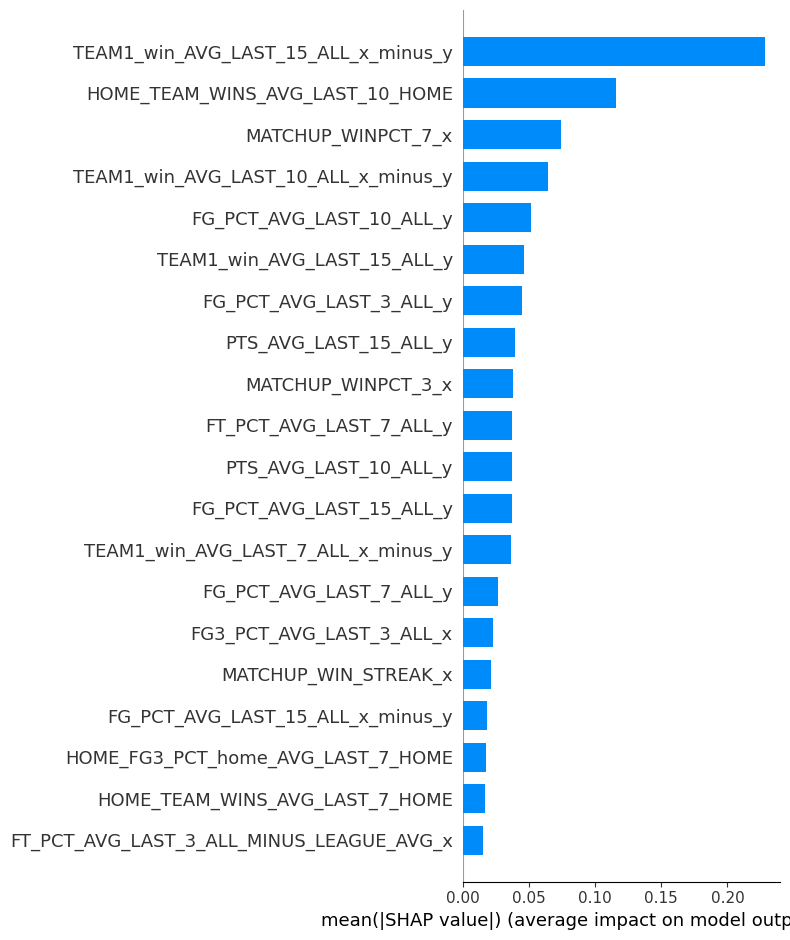

TEST2

Scores:

Accuracy Score: 0.668918918918919
AUC Score: 0.6453804347826086
Optimal Threshold: 0.5553331
              precision    recall  f1-score   support

           0       0.68      0.87      0.77        92
           1       0.61      0.34      0.44        56

    accuracy                           0.67       148
   macro avg       0.65      0.60      0.60       148
weighted avg       0.66      0.67      0.64       148



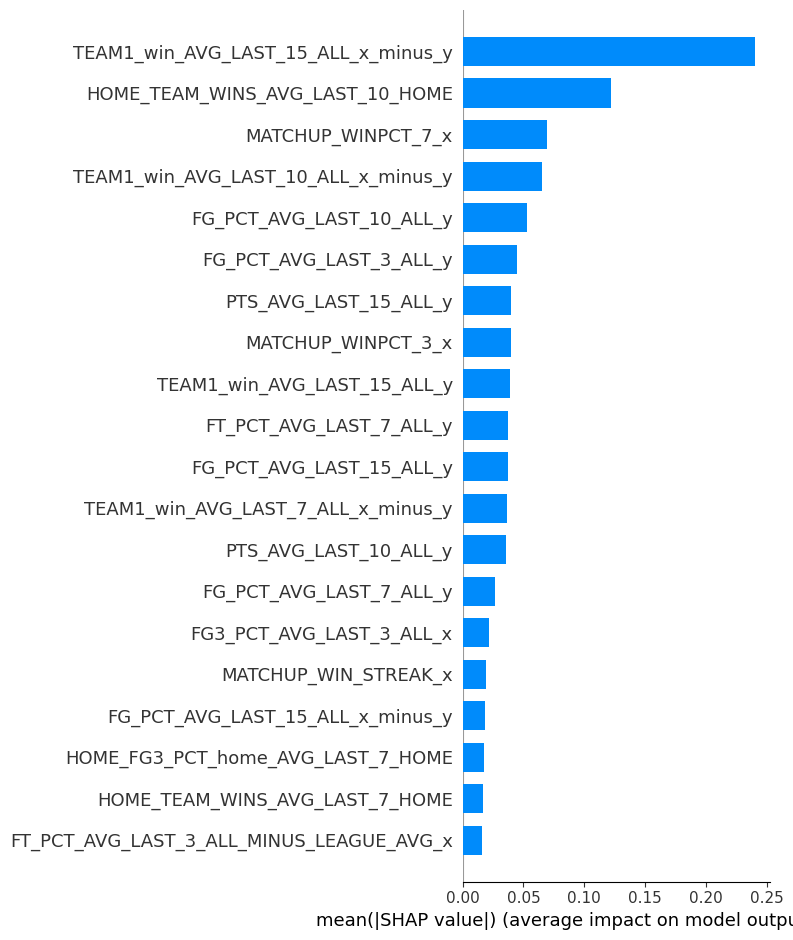

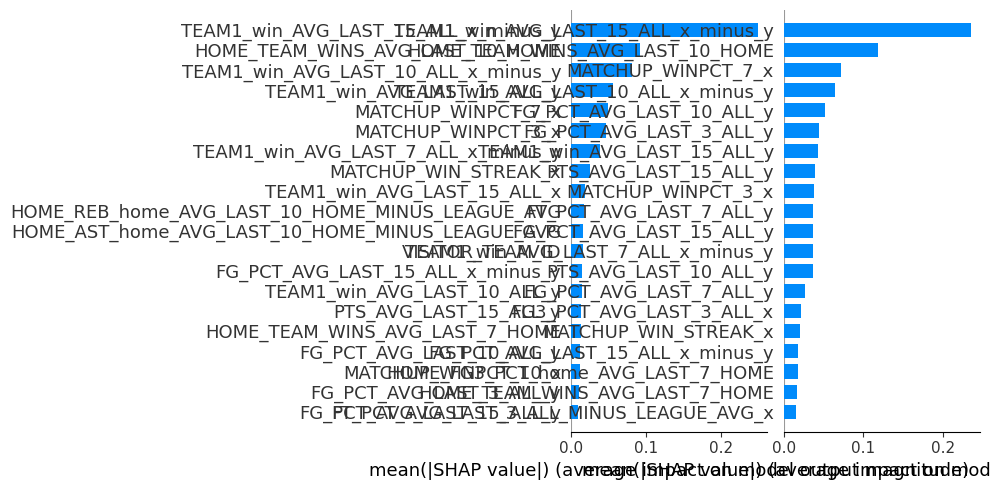

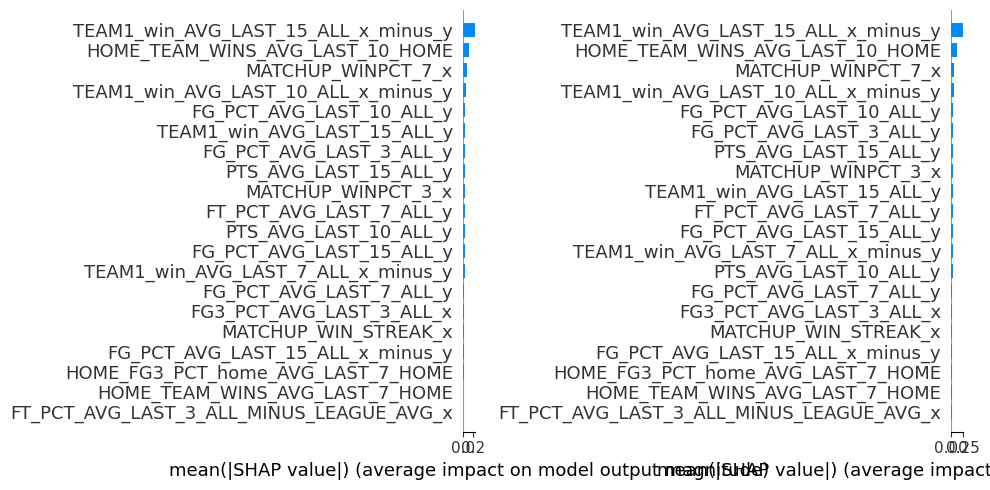

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 86 operations to synchronize with Neptune. Do not kill this process.
All 86 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/cmunch1/nba-prediction/e/NBAP-146


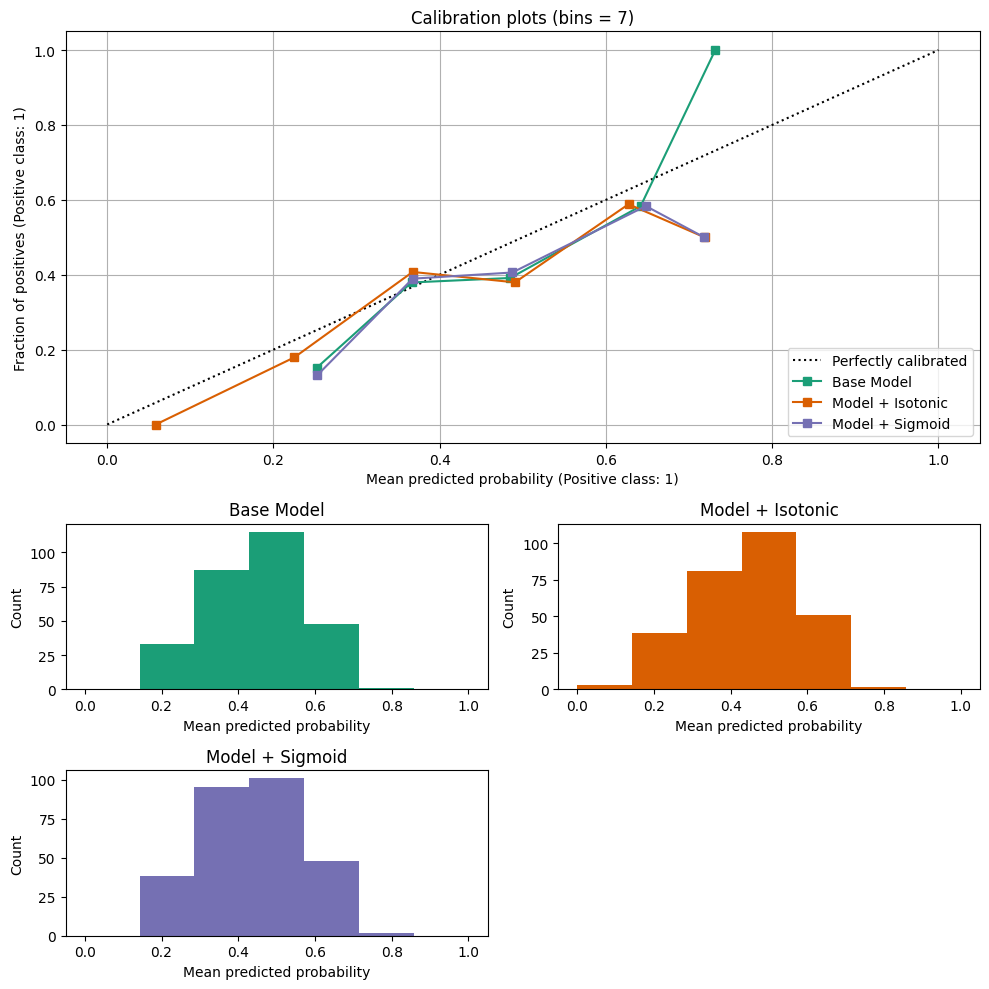

Best calibrated model is:  Model + Isotonic


In [12]:
%run 07_model_testing.ipynb


**Save to Model Registry**



In [13]:
# read in train_predictions to create model schema
train = pd.read_csv(DATAPATH / "train_predictions.csv")
target = train['TARGET']
drop_columns = ['TARGET', 'PredictionPct', 'Prediction']
train = train.drop(columns=drop_columns)

input_schema = Schema(train)
output_schema = Schema(target)
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

# read in model meta_data from training run
with open('model_data.json', 'rb') as fp:
    model_data = json.load(fp)
    

# log back in to hopsworks.ai. Hyperparameter tuning may take hours.
project = hopsworks.login(api_key_value=HOPSWORKS_API_KEY)
mr = project.get_model_registry()

model = mr.sklearn.create_model(
    name = model_data['model_name'],
    metrics = model_data['metrics'],
    description = (model_data['model_name'] + ", calibration_method: " + model_data['calibration_method'] + ", brier_loss: " + str(model_data['brier_loss'])), 
    model_schema = model_schema
)
model.save('model.pkl')










Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/3350
Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Model created, explore it at https://c.app.hopsworks.ai:443/p/3350/models/xgboost/8


Model(name: 'xgboost', version: 8)